# Statcast pitch level data load comparison

***Author***: Jensen Holm <br>
***Date***: 10/21/2024

In [1]:
import pybaseball
import datetime
import polars as pl
import pandas as pd
import duckdb
from plotnine import *
import time

yesterday = datetime.datetime.now() - datetime.timedelta(days=1)

dataset_url = 'hf://datasets/Jensen-holm/statcast-era-pitches/data/statcast_era_pitches.parquet'

### pybaseball benchmark

In [2]:
pb_start_time = time.time()

_ = pybaseball.statcast(
    start_dt="2015-01-01",
    end_dt=yesterday.strftime("%Y-%m-%d"),
)

pb_time = time.time() - pb_start_time

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


100%|██████████| 2133/2133 [21:48<00:00,  1.63it/s]
/Users/jensen/Documents/projects/statcast-era-pitches/venv/lib/python3.12/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


-1358.0838248729706

### polars benchmark

In [3]:
pl_start_time = time.time()

_ = pl.read_parquet(dataset_url)

pl_time = time.time() - pl_start_time

26.899266004562378

### pandas benchmark

In [4]:
pd_start_time = time.time()

_ = pd.read_parquet(dataset_url)

pd_time = time.time() - pd_start_time

/Users/jensen/Documents/projects/statcast-era-pitches/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


33.09332203865051

### Duckdb benchmark

In [20]:
con = duckdb.connect()

con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")

ddb_start_time = time.time()

result = con.sql(
    f"""
    SELECT *
    FROM '{dataset_url}';
    """
)

_ = result.fetchall()

ddb_time = time.time() - ddb_start_time

## Results

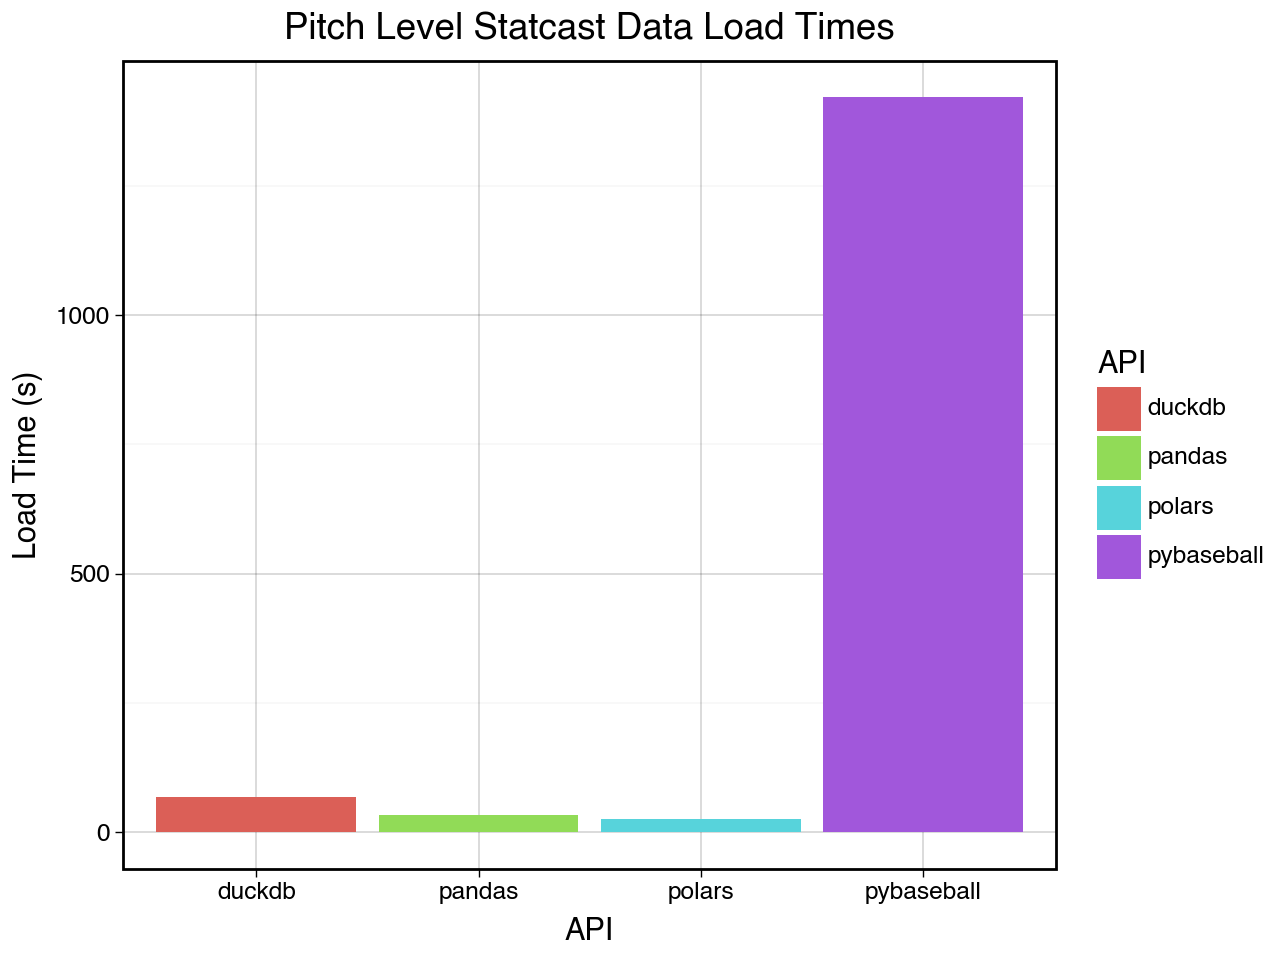

In [22]:
result_df = pl.from_dict({
    "Load Time (s)": [pb_time, pl_time, pd_time, ddb_time],
    "API": ["pybaseball", "polars", "pandas", "duckdb"],
})

plot = (
    ggplot(result_df, aes(x="API", y="Load Time (s)", fill="API"))
    + geom_bar(stat="identity")
    + theme_linedraw()
    + labs(title="Pitch Level Statcast Data Load Times")
)

plot

In [23]:

result_df.write_clipboard()

Load Time (s),API
f64,str
1421.103318,"""pybaseball"""
26.899266,"""polars"""
33.093322,"""pandas"""
68.692873,"""duckdb"""
